# 4. Descriptive Statistics

> **Purpose:**  
> This notebook computes **descriptive statistics** for both the original and LLM-generated Asset Administration Shells (AAS).  
> These statistics provide an overview of structural properties and allow comparison across companies and submodels.


## 4.0 Imports

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from itertools import product
from basyx.aas.model.submodel import SubmodelElementCollection, Property, MultiLanguageProperty, File, Range
import basyx.aas.adapter.json
data_path = '/app/data'
processing_path = os.path.join(data_path,'processed/sample')
metadata_path = os.path.join(processing_path,'metadata.csv')
metadata_df = pd.read_csv(metadata_path)

## 4.1 Property and Segment Counts by Company

This section calculates and summarizes the number of properties and submodel segments per company.
The statistics help to identify patterns in AAS complexity and coverage across different manufacturers.

In [5]:
statistics = {}
companies = metadata_df.Company.unique()
product_ids = os.listdir(processing_path)

# Print header
print(f"{'Company':<20} {'Median':>8} {'Mean':>8} {'Std Dev':>8} {'Segm':>6} {'Groups':>6} {'Classes':>8} {'Subcls':>8}")
print("-" * 80)

all_property_counts = []
all_eclass_ids = []

for company in companies:
    company_statistics = {}
    property_counts = list(metadata_df[metadata_df['Company'] == company].n_Properties)
    eclass_ids = list(metadata_df[metadata_df['Company'] == company]['Class_Id'])

    
    company_statistics['avg_property_count'] = np.mean(property_counts)
    company_statistics['std_property_count'] = np.std(property_counts)
    company_statistics['median_property_count'] = int(np.median(property_counts))
    company_statistics['n_segments'] = len(set([str(int(i))[:2] for i in eclass_ids]))
    company_statistics['n_groups'] = len(set([str(int(i))[:4] for i in eclass_ids]))
    company_statistics['n_classes'] = len(set([str(int(i))[:6] for i in eclass_ids]))
    company_statistics['n_subclasses'] = len(set([str(int(i)) for i in eclass_ids]))

    print(f"{company:<20} "
          f"{company_statistics['median_property_count']:>8} "
          f"{company_statistics['avg_property_count']:>8.1f} "
          f"{company_statistics['std_property_count']:>8.1f} "
          f"{company_statistics['n_segments']:>6} "
          f"{company_statistics['n_groups']:>6} "
          f"{company_statistics['n_classes']:>8} "
          f"{company_statistics['n_subclasses']:>8}")

    statistics[company] = company_statistics
    all_property_counts.extend(property_counts)
    all_eclass_ids.extend(eclass_ids)

# ---- Compute overall statistics ----
overall_statistics = {
    'avg_property_count': np.mean(all_property_counts),
    'std_property_count': np.std(all_property_counts),
    'median_property_count': int(np.median(all_property_counts)),
    'n_segments': len(set([str(int(i))[:2] for i in all_eclass_ids])),
    'n_groups': len(set([str(int(i))[:4] for i in all_eclass_ids])),
    'n_classes': len(set([str(int(i))[:6] for i in all_eclass_ids])),
    'n_subclasses': len(set([str(int(i)) for i in all_eclass_ids]))
}

# Add to dictionary
statistics['Overall'] = overall_statistics

# Print overall row
print("-" * 80)
print(f"{'Overall':<20} "
      f"{overall_statistics['median_property_count']:>8} "
      f"{overall_statistics['avg_property_count']:>8.1f} "
      f"{overall_statistics['std_property_count']:>8.1f} "
      f"{overall_statistics['n_segments']:>6} "
      f"{overall_statistics['n_groups']:>6} "
      f"{overall_statistics['n_classes']:>8} "
      f"{overall_statistics['n_subclasses']:>8}")

Company                Median     Mean  Std Dev   Segm Groups  Classes   Subcls
--------------------------------------------------------------------------------
Wago                       37     35.4     12.3      1      1        1        5
Harting                    34     36.8      4.8      2      5        6       18
RStahl                     76     86.4     33.9      1      5        6        8
Festo                      24     23.9      9.7      3     10       21       30
--------------------------------------------------------------------------------
Overall                    37     45.6     30.6      4     17       33       60


## 4.2 Generated AAS Statistics

Statistics for LLM-generated AAS are computed here, including number of properties per submodel.

In [6]:
log_path = os.path.join(processing_path, "experiment_log.csv")
log_df = pd.read_csv(log_path)
def filter_and_concat(
    df,
    fixed_filters=None,
    sweep=None,
    one_per_product_id=False,
    float_tolerance=1e-8
):
    """
    Filters a DataFrame by fixed columns and optionally sweeps over one or more columns.
    
    Args:
        df: Pandas DataFrame to filter.
        fixed_filters: Dict of fixed column filters (single values only).
                       Example: {"name": "trial1"}
        sweep: Dict of columns to sweep with lists of values.
               Example: {"model": ["gpt-4", "gpt-4o-mini"], "temperature": [0.5, 1.0]}
        one_per_product_id: Whether to deduplicate by product_id.
        float_tolerance: Tolerance for floating-point matching.

    Returns:
        Filtered concatenated DataFrame.
    """
    filtered_df = pd.DataFrame()
    fixed_filters = fixed_filters or {}
    sweep = sweep or {}

    # Generate all combinations of sweep values (cartesian product)
    sweep_keys = list(sweep.keys())
    sweep_values_product = product(*sweep.values()) if sweep else [()]

    for sweep_combo in sweep_values_product:
        subset = df.copy()

        # Apply fixed filters
        for col, val in fixed_filters.items():
            subset = subset[
                subset[col].between(val - float_tolerance, val + float_tolerance)
                if np.issubdtype(type(val), np.floating) else subset[col] == val
            ]

        # Apply sweep filters
        sweep_filters = dict(zip(sweep_keys, sweep_combo))
        for col, val in sweep_filters.items():
            subset = subset[
                subset[col].between(val - float_tolerance, val + float_tolerance)
                if np.issubdtype(type(val), np.floating) else subset[col] == val
            ]

        # Deduplicate if needed
        if one_per_product_id:
            subset = subset.sort_values("product_id").drop_duplicates("product_id", keep="last")

        # Print filter summary
        filter_summary = {**fixed_filters, **sweep_filters}
        print(f"{len(subset)} rows: {filter_summary}")

        filtered_df = pd.concat([filtered_df, subset], ignore_index=True)

    return filtered_df


filtered_dfs = {}

# Qwen3 models as sweep
qwen3_models = ['qwen3:0.6b','qwen3:1.7b','qwen3:4b','qwen3:8b','qwen3:14b','qwen3:30b','qwen3:32b']
filtered_dfs['qwen3'] = filter_and_concat(
    log_df,
    fixed_filters={"name": "deepseek_40960_context"},
    sweep={"model": qwen3_models},
    one_per_product_id=True
)

# DeepSeek models as sweep
deepseek_models = ['deepseek-r1:1.5b','deepseek-r1:7b','deepseek-r1:8b','deepseek-r1:14b','deepseek-r1:32b','deepseek-r1:70b']
filtered_dfs['deepseek'] = filter_and_concat(
    log_df,
    fixed_filters={"name": "deepseek_40960_context"},
    sweep={"model": deepseek_models},
    one_per_product_id=True
)

# Temperature sweep for gpt-4o-mini
temperatures = np.linspace(1.2, 1.9, 8)
filtered_dfs['temperature'] = filter_and_concat(
    log_df,
    fixed_filters={"name": "experiments_test_sample_3", "model": "gpt-4o-mini"},
    sweep={"temperature": temperatures},
    one_per_product_id=True
)

# Prompt degradation sweep for gpt-4o-mini
intensities = np.linspace(0.0, 1.0, 11)
filtered_dfs['prompt'] = filter_and_concat(
    log_df,
    fixed_filters={"model": "gpt-4o-mini", "temperature": 0.0},
    sweep={"prompt_degradation_intensity": intensities},
    one_per_product_id=True
)


filtered_df = pd.DataFrame()
for key in filtered_dfs:
    filtered_df = pd.concat([filtered_df,filtered_dfs[key]])
log_df = log_df[log_df['result_path'].isin(filtered_df['result_path'])]

200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:0.6b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:1.7b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:4b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:8b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:14b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:30b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'qwen3:32b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:1.5b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:7b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:8b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:14b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:32b'}
200 rows: {'name': 'deepseek_40960_context', 'model': 'deepseek-r1:70b'}
200 rows: {'name': 'experiments_test_sample_3', 'model': 'gpt-4o-mini', 'temperature': np.floa

In [7]:
# Count total number of generated AAS submodels
n_generated_aas = 0
for key,df in filtered_dfs.items():
    n_generated_aas += len(df)
print(f'{n_generated_aas}: Total number of generated submodels')

6400: Total number of generated submodels


In [8]:
# number of generated properties and ratio to original number of properties
log_df['n_generated_properties'] = 0
all_properties = []
for i,row in log_df.iterrows():
    with open(row['result_path'],'r') as file:
        technical_properties = json.load(file,cls=basyx.aas.adapter.json.AASFromJsonDecoder).get_referable('TechnicalProperties')
        props = []
        for prop in technical_properties:
            if type(prop) == Property:
                props.append(prop)
            elif type(prop) == SubmodelElementCollection:
                for subprop in prop:
                    if type(subprop) == Property:
                        props.append(subprop)
                    else:
                        raise ValueError(f"Unexpected Structure {prop} ### {subprop}")
            else:
                raise ValueError(f"Unexpected Structure {prop}")

        all_properties += props
        log_df.loc[i, 'n_generated_properties'] = len(props)
        product_id = row['product_id']
        log_df.loc[i, 'property_ratio'] = len(props) / metadata_df[metadata_df['Product_Id']==product_id].n_Properties.values[0]
log_df

,product_id,date,commit_hash,config_hash,result_path,classification_system,name,model,client,property_keys_in_prompt,temperature,prompt_hint,prompt_degradation_intensity,batch_size,retry,response_format,n_generated_properties,property_ratio
0,Festo_1254042,2025-07-22_13-18-40,8078a73,015288c0,/app/data/processed/sample/Festo_1254042/Festo...,CustomDictionary,deepseek_40960_context,qwen3:1.7b,ollama,"['unit', 'datatype']",0.0,NaN,0.0,0,20,ExtractionResult,18,1.000000
1,Festo_1254042,2025-07-23_21-06-16,8078a73,04512d16,/app/data/processed/sample/Festo_1254042/Festo...,CustomDictionary,deepseek_40960_context,qwen3:32b,ollama,"['unit', 'datatype']",0.0,NaN,0.0,0,20,ExtractionResult,18,1.000000
2,Festo_1254042,2025-07-22_22-39-04,093f2cd,11e89954,/app/data/processed/sample/Festo_1254042/Festo...,CustomDictionary,experiments_test_sample_3,gpt-4o-mini,openai,"['unit', 'datatype']",0.0,NaN,0.7,0,20,ExtractionResult,17,0.944444
3,Festo_1254042,2025-07-22_17-18-47,093f2cd,163b2d70,/app/data/processed/sample/Festo_1254042/Festo...,CustomDictionary,experiments_test_sample_3,gpt-4o-mini,openai,"['unit', 'datatype']",1.8,NaN,0.0,0,20,ExtractionResult,18,1.000000
4,Festo_1254042,2025-07-22_22-22-45,093f2cd,240434db,/app/data/processed/sample/Festo_1254042/Festo...,CustomDictionary,experiments_test_sample_3,gpt-4o-mini,openai,"['unit', 'datatype']",0.0,NaN,0.6,0,20,ExtractionResult,18,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442,Wago_781-607_999-950,2025-07-18_11-19-47,093f2cd,dc643eb7,/app/data/processed/sample/Wago_781-607_999-95...,CustomDictionary,experiments_test_sample_3,gpt-4o-mini,openai,"['unit', 'datatype']",1.3,NaN,0.0,0,20,ExtractionResult,35,0.972222
6443,Wago_781-607_999-950,2025-07-17_20-55-18,093f2cd,ebcfabd8,/app/data/processed/sample/Wago_781-607_999-95...,CustomDictionary,experiments_test_sample_3,gpt-4o-mini,openai,"['unit', 'datatype']",0.0,NaN,0.3,0,20,ExtractionResult,34,0.944444
6444,Wago_781-607_999-950,2025-07-17_22-37-23,093f2cd,f3ddd877,/app/data/processed/sample/Wago_781-607_999-95...,CustomDictionary,experiments_test_sample_3,gpt-4o-mini,openai,"['unit', 'datatype']",0.0,NaN,0.4,0,20,ExtractionResult,35,0.972222
6445,Wago_781-607_999-950,2025-07-19_20-09-31,8078a73,f6743de1,/app/data/processed/sample/Wago_781-607_999-95...,CustomDictionary,deepseek_40960_context,qwen3:0.6b,ollama,"['unit', 'datatype']",0.0,NaN,0.0,0,20,ExtractionResult,21,0.583333


In [9]:
# Prompt degradation sweep of the log_df for gpt-4o-mini
intensities = np.linspace(0.0, 1.0, 11)
filtered_dfs['prompt'] = filter_and_concat(
    log_df,
    fixed_filters={"model": "gpt-4o-mini", "temperature": 0.0},
    sweep={"prompt_degradation_intensity": intensities},
    one_per_product_id=True
)


200 rows: {'model': 'gpt-4o-mini', 'temperature': 0.0, 'prompt_degradation_intensity': np.float64(0.0)}
200 rows: {'model': 'gpt-4o-mini', 'temperature': 0.0, 'prompt_degradation_intensity': np.float64(0.1)}
200 rows: {'model': 'gpt-4o-mini', 'temperature': 0.0, 'prompt_degradation_intensity': np.float64(0.2)}
200 rows: {'model': 'gpt-4o-mini', 'temperature': 0.0, 'prompt_degradation_intensity': np.float64(0.30000000000000004)}
200 rows: {'model': 'gpt-4o-mini', 'temperature': 0.0, 'prompt_degradation_intensity': np.float64(0.4)}
200 rows: {'model': 'gpt-4o-mini', 'temperature': 0.0, 'prompt_degradation_intensity': np.float64(0.5)}
200 rows: {'model': 'gpt-4o-mini', 'temperature': 0.0, 'prompt_degradation_intensity': np.float64(0.6000000000000001)}
200 rows: {'model': 'gpt-4o-mini', 'temperature': 0.0, 'prompt_degradation_intensity': np.float64(0.7000000000000001)}
200 rows: {'model': 'gpt-4o-mini', 'temperature': 0.0, 'prompt_degradation_intensity': np.float64(0.8)}
200 rows: {'model'

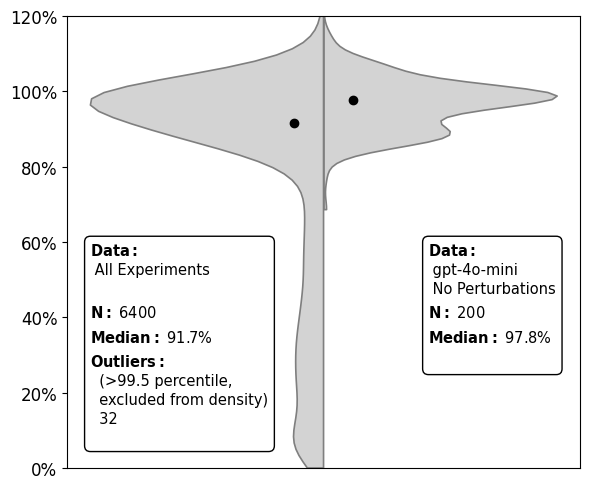

In [10]:
# Remove outliers (>99.5th percentile based on each dataset)
def trim_percentiles(data, lower=0.0, upper=99.5):
    lb = np.percentile(data, lower)
    ub = np.percentile(data, upper)
    return data[(data >= lb) & (data <= ub)]
property_ratios1 = filtered_dfs['prompt'][filtered_dfs['prompt']['prompt_degradation_intensity']==0.0]['property_ratio']
property_ratios2 = log_df['property_ratio']

trimmed2 = property_ratios1 # no trimming needed
trimmed1 = trim_percentiles(property_ratios2)

# For plotting only (originals still used for stats)
df_trimmed = pd.DataFrame({
    'property_ratio': np.concatenate([trimmed1, trimmed2]),
    'Model': ['gpt-4o-mini (No Perturbations)'] * len(trimmed1) +
             ['All Experiments'] * len(trimmed2),
    'SplitLabel': ['Both'] * (len(trimmed1) + len(trimmed2))
})

def describe_data(data, title, lower=0, upper=100):
    lower_bound = np.percentile(data, lower)
    upper_bound = np.percentile(data, upper)
#    low_outliers = data[data < lower_bound]
    high_outliers = data[data > upper_bound]
    median_val = np.median(data)

    legend_text = (r"$\mathbf{Data:}$"f'\n\n\n\n {title}\n\n\n\n\n'
                   r"$\mathbf{N:}$"f' {len(data)}\n\n\n\n\n'
                   r"$\mathbf{Median:}$"f' {median_val*100:.1f}%\n\n\n\n\n')
    if len(high_outliers) > 0: 
        legend_text += (r"$\mathbf{Outliers:}$"f'\n\n\n\n'
                   f'  (>99.5 percentile,\n\n\n\n'
                   f'  excluded from density)\n\n\n\n'
                   f'  {len(high_outliers)}\n\n\n\n'
                   )
    return legend_text, median_val, lower_bound, upper_bound

# Calculate stats for annotations and y-limit
desc1, med1, lb1, ub1 = describe_data(property_ratios1, "gpt-4o-mini\n\n\n\n No Perturbations")
desc2, med2, lb2, ub2 = describe_data(property_ratios2, "All Experiments\n\n\n\n", upper=99.5)

y_min = min(lb1, lb2)
y_max = max(ub1, ub2)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

sns.violinplot(
    data=df_trimmed,
    x="SplitLabel",
    y="property_ratio",
    hue="Model",
    split=True,
    inner=None,
    linewidth=1.2,
    palette=["lightgray", "lightgray"],
    cut=0,
    ax=ax
)

# Add medians (original data)
ax.plot(-0.05, med2, 'o', color='black', markersize=6, zorder=3)
ax.plot(+0.05, med1, 'o', color='black', markersize=6, zorder=3)

# Y-axis
ax.set_ylim(0, 1.2)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticks([])
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))
ax.tick_params(axis='y', labelsize=12)
ax.legend_.remove()

# Annotations
ax.text(-0.4, y_min + 0.60, desc2, fontsize=10.5, va='top', ha='left', linespacing=0.15,
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='black', facecolor='white'))
ax.text(0.18, y_min + 0.60, desc1, fontsize=10.5, va='top', ha='left', linespacing=0.15,
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.savefig('figure3.svg', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
mean_val1 = np.mean(property_ratios1)
print(f"{mean_val1*100:.1f}: average ratio of extracted properties.")
mean_val2 = np.mean(property_ratios2)
print(f"{mean_val2*100:.1f}: average ratio of extracted properties.")

96.8: average ratio of extracted properties.
83.5: average ratio of extracted properties.


In [12]:
print(f"{int(log_df.n_generated_properties.sum())}: Total Generated Properties")
print(f"{len(all_properties)}: Total Generated Properties")

231276: Total Generated Properties
231276: Total Generated Properties
